In [1]:
%pylab inline
import librosa
import librosa.filters
import math
import numpy as np
from scipy import signal

import glob
import os

from scipy.io import wavfile
from scipy import interpolate
import pyworld, pysptk
from nnmnkwii.metrics import melcd
from fastdtw import fastdtw

import matplotlib.pyplot as plt
from IPython.display import Audio

import soundfile as sf

Populating the interactive namespace from numpy and matplotlib


In [2]:
base1 = os.path.expanduser("../../dataset/wav_data/uemura_normal/")
base2 = os.path.expanduser("../../dataset/wav_data/tsuchiya_normal/")

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

# from https://github.com/keithito/tacotron/blob/08989cc3553b3a916a31f565e4f20e34bf19172f/hparams.py
hparams = AttrDict(
    # Audio:
    num_mels=80,
    num_freq=1025,
    sample_rate=24000,
    frame_length_ms=50,
    frame_shift_ms=12.5,
    preemphasis=0.97,
    min_level_db=-100,
    ref_level_db=20,
)

## functions

In [3]:
# from https://github.com/keithito/tacotron/blob/53a840c030a1899a0510da4965d96b53a29d6679/util/audio.py

def load_wav(path):
    w = librosa.core.load(path, sr=hparams.sample_rate)[0]
    w = librosa.effects.remix(w, intervals=librosa.effects.split(w, top_db=25))
#     w = librosa.effects.trim(w)[0]
    return w


def save_wav(wav, path):
    wav *= 32767 / max(0.01, np.max(np.abs(wav)))
    sf.write(path, wav, 44100, 'PCM_24')


def preemphasis(x):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)


def inv_preemphasis(x):
    return signal.lfilter([1], [1, -hparams.preemphasis], x)


def spectrogram(y):
    D = _stft(preemphasis(y))
    S = _amp_to_db(np.abs(D)) - hparams.ref_level_db
    return _normalize(S)


def inv_spectrogram(spectrogram):
    '''Converts spectrogram to waveform using librosa'''
    S = _db_to_amp(_denormalize(spectrogram) + hparams.ref_level_db)    # Convert back to linear
    return inv_preemphasis(_griffin_lim(S ** hparams.power))                    # Reconstruct phase


def inv_spectrogram_tensorflow(spectrogram):
    '''Builds computational graph to convert spectrogram to waveform using TensorFlow.
    Unlike inv_spectrogram, this does NOT invert the preemphasis. The caller should call
    inv_preemphasis on the output after running the graph.
    '''
    S = _db_to_amp_tensorflow(_denormalize_tensorflow(spectrogram) + hparams.ref_level_db)
    return _griffin_lim_tensorflow(tf.pow(S, hparams.power))


def melspectrogram(y):
    D = _stft(preemphasis(y))
    S = _amp_to_db(_linear_to_mel(np.abs(D)))
    return _normalize(S)


def find_endpoint(wav, threshold_db=-40, min_silence_sec=0.8):
    window_length = int(hparams.sample_rate * min_silence_sec)
    hop_length = int(window_length / 4)
    threshold = _db_to_amp(threshold_db)
    for x in range(hop_length, len(wav) - window_length, hop_length):
        if np.max(wav[x:x+window_length]) < threshold:
            return x + hop_length
    return len(wav)


def _griffin_lim(S):
    '''librosa implementation of Griffin-Lim
    Based on https://github.com/librosa/librosa/issues/434
    '''
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
    S_complex = np.abs(S).astype(np.complex)
    y = _istft(S_complex * angles)
    for i in range(hparams.griffin_lim_iters):
        angles = np.exp(1j * np.angle(_stft(y)))
        y = _istft(S_complex * angles)
    return y


def _griffin_lim_tensorflow(S):
    '''TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    with tf.variable_scope('griffinlim'):
        # TensorFlow's stft and istft operate on a batch of spectrograms; create batch of size 1
        S = tf.expand_dims(S, 0)
        S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
        y = _istft_tensorflow(S_complex)
        for i in range(hparams.griffin_lim_iters):
            est = _stft_tensorflow(y)
            angles = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64)
            y = _istft_tensorflow(S_complex * angles)
        return tf.squeeze(y, 0)


def _stft(y):
    n_fft, hop_length, win_length = _stft_parameters()
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y):
    _, hop_length, win_length = _stft_parameters()
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)


def _stft_tensorflow(signals):
    n_fft, hop_length, win_length = _stft_parameters()
    return tf.contrib.signal.stft(signals, win_length, hop_length, n_fft, pad_end=False)


def _istft_tensorflow(stfts):
    n_fft, hop_length, win_length = _stft_parameters()
    return tf.contrib.signal.inverse_stft(stfts, win_length, hop_length, n_fft)


def _stft_parameters():
    n_fft = (hparams.num_freq - 1) * 2
    hop_length = int(hparams.frame_shift_ms / 1000 * hparams.sample_rate)
    win_length = int(hparams.frame_length_ms / 1000 * hparams.sample_rate)
    return n_fft, hop_length, win_length


# Conversions:

_mel_basis = None

def _linear_to_mel(spectrogram):
    global _mel_basis
    if _mel_basis is None:
        _mel_basis = _build_mel_basis()
    return np.dot(_mel_basis, spectrogram)

def _build_mel_basis():
    n_fft = (hparams.num_freq - 1) * 2
    return librosa.filters.mel(hparams.sample_rate, n_fft, n_mels=hparams.num_mels)

def _amp_to_db(x):
    return 20 * np.log10(np.maximum(1e-5, x))

def _db_to_amp(x):
    return np.power(10.0, x * 0.05)

def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)

def _normalize(S):
    return np.clip((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)

def _denormalize(S):
    return (np.clip(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db

def _denormalize_tensorflow(S):
    return (tf.clip_by_value(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db

## DTW aligtner

In [4]:
# from https://github.com/r9y9/nnmnkwii/blob/4cade86b5c35b4e35615a2a8162ddc638018af0e/nnmnkwii/preprocessing/alignment.py#L14
class DTWAligner(object):
    def __init__(self, dist=lambda x, y: norm(x - y), radius=1, verbose=0):
        self.verbose = verbose
        self.dist = dist
        self.radius = radius

    def transform(self, XY_src, XY_dst=None):
        if XY_dst is None:
            XY_dst = XY_src

        X_src, Y_src = XY_src
        X_dst, Y_dst = XY_dst
        assert X_src.ndim == 3 and Y_src.ndim == 3
        assert X_dst.ndim == 3 and Y_dst.ndim == 3

        longer_features = X_dst if X_dst.shape[1] > Y_dst.shape[1] else Y_dst

        X_aligned = np.zeros_like(longer_features)
        Y_aligned = np.zeros_like(longer_features)
        for idx, (x_src, y_src, x_dst, y_dst) in enumerate(zip(X_src, Y_src, X_dst, Y_dst)):
            dist, path = fastdtw(x_src, y_src, radius=self.radius, dist=self.dist)
            dist /= (len(x_src) + len(y_src))

            pathx = np.array(list(map(lambda l: l[0], path))) / len(x_src)
            pathx = interpolate.interp1d(np.linspace(0, 1, len(pathx)), pathx)(np.linspace(0, 1, len(x_dst)))
            pathx = np.floor(pathx * len(x_dst)).astype(np.int)

            pathy = np.array(list(map(lambda l: l[1], path))) / len(y_src)
            pathy = interpolate.interp1d(np.linspace(0, 1, len(pathy)), pathy)(np.linspace(0, 1, len(y_dst)))
            pathy = np.floor(pathy * len(y_dst)).astype(np.int)

            x_dst, y_dst = x_dst[pathx], y_dst[pathy]
            max_len = max(len(x_dst), len(y_dst))
            if max_len > X_aligned.shape[1] or max_len > Y_aligned.shape[1]:
                pad_size = max(max_len - X_aligned.shape[1],
                               max_len > Y_aligned.shape[1])
                X_aligned = np.pad(
                    X_aligned, [(0, 0), (0, pad_size), (0, 0)],
                    mode="constant", constant_values=0)
                Y_aligned = np.pad(
                    Y_aligned, [(0, 0), (0, pad_size), (0, 0)],
                    mode="constant", constant_values=0)
            X_aligned[idx][:len(x_dst)] = x_dst
            Y_aligned[idx][:len(y_dst)] = y_dst
            if self.verbose > 0:
                print("{}, distance: {}".format(idx, dist))
        return X_aligned, Y_aligned


## extract feature with WORLD

In [5]:
# from https://github.com/r9y9/nnmnkwii/blob/8afc05cce5b8a6727ed5d0fb874c1ae4e4039f1e/tests/test_real_datasets.py#L113
fs = hparams.sample_rate
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 25
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))

def collect_features(x, fs):
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    return mc

## make feature & spectrogram & mel frequency spectrogram

In [40]:
feature1 = []
feature2 = []
mel1 = []
mel2 = []
spec1 = []
spec2 = []

for i in range(100):
    p = glob.glob(os.path.join(base1, '*{0:03}*'.format(i+1)))[0]
    w = load_wav(p)
    m1 = melspectrogram(w).astype(np.float32)
    s1 = _stft(w)
    f1 = collect_features(w, fs).T

    p = glob.glob(os.path.join(base2, '*{0:03}*'.format(i+1)))[0]
    w = load_wav(p)
    m2 = melspectrogram(w).astype(np.float32)
    s2 = _stft(w)
    f2 = collect_features(w, fs).T
    
    m = max(f1.shape[-1], f2.shape[-1])
    f1 = np.pad(f1, ((0, 0), (0, m - f1.shape[-1])), mode='edge')
    f2 = np.pad(f2, ((0, 0), (0, m - f2.shape[-1])), mode='edge')

    m = max(s1.shape[-1], s2.shape[-1])
    s1 = np.pad(s1, ((0, 0), (0, m - s1.shape[-1])), mode='edge')
    s2 = np.pad(s2, ((0, 0), (0, m - s2.shape[-1])), mode='edge')

    m = max(m1.shape[-1], m2.shape[-1])
    m1 = np.pad(m1, ((0, 0), (0, m - m1.shape[-1])), mode='edge')
    m2 = np.pad(m2, ((0, 0), (0, m - m2.shape[-1])), mode='edge')

    feature1.append(f1)
    feature2.append(f2)
    spec1.append(s1)
    spec2.append(s2)
    mel1.append(m1)
    mel2.append(m2)

## raw voice

In [34]:
idx = 2

w = _istft(spec1[idx])
save_wav(w, 'data/raw-voice-1-{0:03}.wav'.format(idx))
Audio(w, rate=hparams.sample_rate)

In [35]:
w = _istft(spec2[idx])
save_wav(w, 'data/raw-voice-2-{0:03}.wav'.format(idx))
Audio(w, rate=hparams.sample_rate)

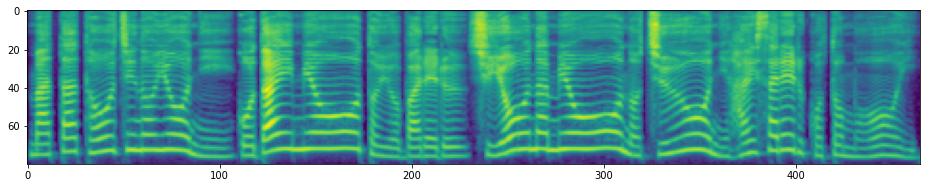

In [9]:
plt.figure(figsize=(16, 8))
plt.imshow(mel1[0][::-1])
plt.savefig('data/raw-melspec-1-{0:03}.svg'.format(idx), bbox_inches="tight", pad_inches=0.0)

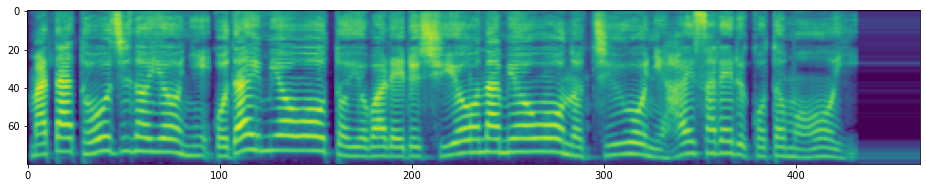

In [10]:
plt.figure(figsize=(16, 8))
plt.imshow(mel2[0][::-1])
plt.savefig('data/raw-melspec-2-{0:03}.svg'.format(idx), bbox_inches="tight", pad_inches=0.0)

## alignment

In [11]:
X, Y = feature1[idx].T[None], feature2[idx].T[None]
spec1_aligned, spec2_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y), (spec1[idx].T[None], spec2[idx].T[None]))
mel1_aligned, mel2_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y), (mel1[idx].T[None], mel2[idx].T[None]))

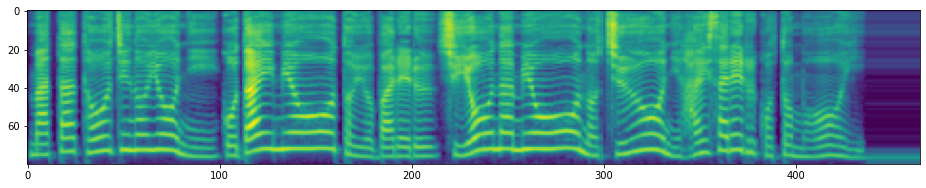

In [12]:
plt.figure(figsize=(16, 8))
plt.imshow(mel1_aligned[0].T[::-1])
plt.savefig('data/aligned-melspec-1-{0:03}.svg'.format(idx), bbox_inches="tight", pad_inches=0.0)

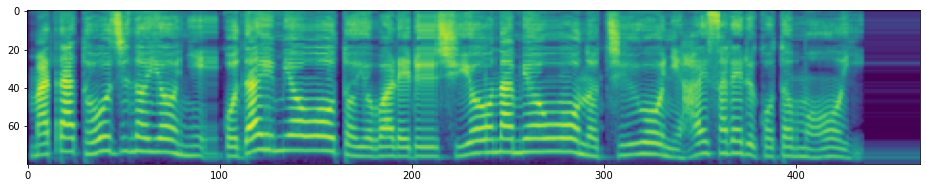

In [13]:
plt.figure(figsize=(16, 8))
plt.imshow(mel2_aligned[0].T[::-1])
plt.savefig('data/aligned-melspec-2-{0:03}.svg'.format(idx), bbox_inches="tight", pad_inches=0.0)

## aligned voice

In [14]:
w = _istft(spec1_aligned[0].T)
save_wav(w, 'data/aligned-voice-1-{0:03}.wav'.format(idx))
Audio(w, rate=hparams.sample_rate)

In [15]:
w = _istft(spec2_aligned[0].T)
save_wav(w, 'data/aligned-voice-2-{0:03}.wav'.format(idx))
Audio(w, rate=hparams.sample_rate)

In [42]:
for idx in range(100):
    w = _istft(spec1[idx])
    save_wav(w, 'data/raw-voice-1/{0:03}.wav'.format(idx))
    w = _istft(spec2[idx])
    save_wav(w, 'data/raw-voice-2/{0:03}.wav'.format(idx))
    X, Y = feature1[idx].T[None], feature2[idx].T[None]
    spec1_aligned, spec2_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y), (spec1[idx].T[None], spec2[idx].T[None]))
    mel1_aligned, mel2_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y), (mel1[idx].T[None], mel2[idx].T[None]))
    w = _istft(spec1_aligned[0].T)
    save_wav(w, 'data/aligned-voice-1/{0:03}.wav'.format(idx))
    w = _istft(spec2_aligned[0].T)
    save_wav(w, 'data/aligned-voice-2/{0:03}.wav'.format(idx))